In [ ]:
import os
import sys
import numpy as np

In [ ]:
from skimage import data, io, filters
import matplotlib.pyplot as plt

In [ ]:
# dimensions of result image
W = 1200
H = 900
CHANNEL_NUM = 3  # we work with rgb images
MAX_VALUE = 255  # max pixel value, required by ppm header
MATHEMATICAL_ERROR = 0.05 #maximum error between the boundaries of the tiles
NUMBER_SIDE_TILES = 4

In [ ]:
def read_image(path):
    # second line of header contains image dimensions
    w, h = np.loadtxt(path, skiprows=1, max_rows=1, dtype=np.int32)
    # skip 3 lines reserved for header and read image
    image = np.loadtxt(path, skiprows=3, dtype=np.uint8).reshape((h, w, CHANNEL_NUM))
    return image

In [ ]:
def write_image(path, img):
    h, w = img.shape[:2]
    # ppm format requires header in special format
    header = f'P3\n{w} {h}\n{MAX_VALUE}\n'
    with open(path, 'w') as f:
        f.write(header)
        for r, g, b in img.reshape((-1, CHANNEL_NUM)):
            f.write(f'{r} {g} {b} ')

In [ ]:
def sum_side_pixels(tile, h, w):
      sum_side_pixels = np.zeros([4, 3])
      for i in range(CHANNEL_NUM):
          #вверх тайла
          sum_side_pixels[0][i] = (np.array(tile[0,:,i])).sum()
          #низ тайла
          sum_side_pixels[1][i] = (np.array(tile[h-1,:,i])).sum()
          #левый бок тайла
          sum_side_pixels[2][i] = (np.array(tile[:,0,i])).sum()
          #правый бок тайла
          sum_side_pixels[3][i] = (np.array(tile[:,w-1,i])).sum()
      return sum_side_pixels


In [48]:
def find_neighbors(first_tile, remaining_tiles, h, w):
  
    sum_side_first_tile = sum_side_pixels(first_tile, h, w)
    neighbors_tile = np.zeros([2, 4])
    neighbors_tile[:] = -1
    
    #side_connection = np.zeros(2)

    for i in range(len(remaining_tiles)):
      min_error_up = 1
      min_error_down = 1
      min_error_left = 1
      min_error_right = 1
      sum_side_remaining_tiles = sum_side_pixels(remaining_tiles[i], h, w)
      for j in range(NUMBER_SIDE_TILES):
        #ищем минимальную погрешность между пикселями граней тайлов
        error_up = (np.abs((sum_side_first_tile[0] - sum_side_remaining_tiles[j])) / sum_side_first_tile[0]).sum()
        error_down = (np.abs((sum_side_first_tile[1] - sum_side_remaining_tiles[j])) / sum_side_first_tile[1]).sum()
        error_left = (np.abs((sum_side_first_tile[2] - sum_side_remaining_tiles[j])) / sum_side_first_tile[2]).sum()
        error_right = (np.abs((sum_side_first_tile[3] - sum_side_remaining_tiles[j])) / sum_side_first_tile[3]).sum()
        #print(i, error_up, error_down, error_left, error_right, sep='\n', end='\n next \n')
        if (min_error_up > error_up):
          min_error_up = error_up
          if (min_error_up <= MATHEMATICAL_ERROR):
            neighbors_tile[0][0] = i
            neighbors_tile[1][0] = j

        if min_error_down > error_down :
          min_error_down = error_down
          if (min_error_down <= MATHEMATICAL_ERROR):
            neighbors_tile[0][1] = i
            neighbors_tile[1][1] = j

        if (min_error_left > error_left):
          min_error_left = error_left
          if (min_error_left <= MATHEMATICAL_ERROR):
            neighbors_tile[0][2] = i
            neighbors_tile[1][2] = j

        if (min_error_right > error_right):
          min_error_right = error_right
          if (min_error_right <= MATHEMATICAL_ERROR):
            neighbors_tile[0][3] = i
            neighbors_tile[1][3] = j

    #проверить вручную соседей 5 и 2
    # sum_side_remaining_tiles = sum_side_pixels(remaining_tiles[5], h, w)
    # for j in range(NUMBER_SIDE_TILES):
    #  error_up = (np.abs((sum_side_first_tile[0] - sum_side_remaining_tiles[j])) / sum_side_first_tile[0]).sum()
    #  error_down = (np.abs((sum_side_first_tile[1] - sum_side_remaining_tiles[j])) / sum_side_first_tile[1]).sum()
    #  error_left = (np.abs((sum_side_first_tile[2] - sum_side_remaining_tiles[j])) / sum_side_first_tile[2]).sum()
    #  error_right = (np.abs((sum_side_first_tile[3] - sum_side_remaining_tiles[j])) / sum_side_first_tile[3]).sum()
    #  print(j, error_up, error_down, error_left, error_right, sep='\n', end='\n next \n')

    # sum_side_remaining_tiles = sum_side_pixels(remaining_tiles[5], h, w)
    # error_down = (np.abs((sum_side_first_tile[1] - sum_side_remaining_tiles[2])) / sum_side_first_tile[1]).sum()
    # print(error_down)
      
    #print(sum_side_first_tile)
      #print()
      #print(np.array((first_tile[0:3][0:3][0])[:][0][:]))

    # #вывод фрагментов
    # image = (remaining_tiles[3])
    # plt.imshow(image)
    # plt.savefig("image.png")

    return neighors_tile


In [49]:
def solve_puzzle(tiles_folder):
    # create placeholder for result image
    # read all tiles in list
    tiles = [read_image(os.path.join(tiles_folder, t)) for t in sorted(os.listdir(tiles_folder))]

    #np.zeros()

    result_img = np.zeros((H, W, CHANNEL_NUM), dtype=np.uint8)
    # scan dimensions of all tiles and find minimal height and width
    dims = np.array([t.shape[:2] for t in tiles])
    h, w = np.min(dims, axis=0)

    # compute grid that will cover image
    # spacing between grid rows = min h
    # spacing between grid columns = min w
    x_nodes = np.arange(0, W, w)
    y_nodes = np.arange(0, H, h)
    xx, yy = np.meshgrid(x_nodes, y_nodes)
    nodes = np.vstack((xx.flatten(), yy.flatten())).T

    #Расположение тайлов в правильном порядке
    number_of_tiles_in_a_row = W // w
    location_tiles = np.arange(0, len(tiles), 1)
    
    for i in range(number_of_tiles_in_a_row - 1):
        find_neighbors(np.array(tiles[i]), np.array(tiles[i+1: ]), h, w)
    #find_neighbors(np.array(tiles[0]), np.array(tiles[0+1: ]), h, w)

    # fill grid with tiles
    for (x, y), tile in zip(nodes, tiles):
        result_img[y: y + h, x: x + w] = tile[:h, :w]
 
    output_path = "image_output.ppm"
    write_image(output_path, result_img)

[[ 8. -1.  3.  2.]
 [ 1. -1.  0.  0.]]
[[ 0. -1. -1. -1.]
 [ 2. -1. -1. -1.]]
[[-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]


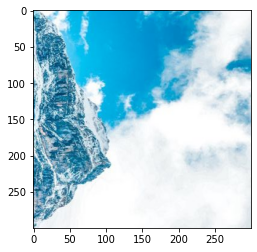

In [50]:
if __name__ == "__main__":
    #directory = sys.argv[1]
    directory = "drive/MyDrive/3Divi/data/0000_0000_0000/tiles"
    solve_puzzle(directory)

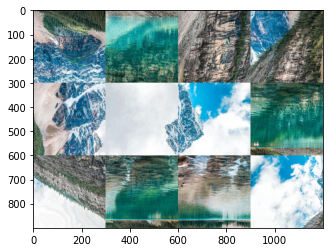

In [ ]:
image = read_image("image_output.ppm")
#edges = filters.sobel(image)
#io.imshow(edges)
#io.show()
plt.imshow(image)
plt.savefig("image.png")

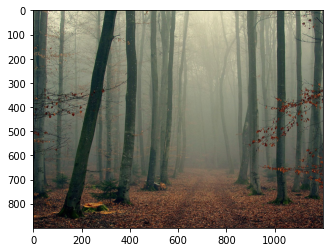

In [42]:
image = read_image("drive/MyDrive/3Divi/data/0000_0000_0003/image.ppm")
#edges = filters.sobel(image)
#io.imshow(edges)
#io.show()
plt.imshow(image)
plt.savefig("image_check.png")